<a href="https://colab.research.google.com/github/janShi1105/science/blob/main/ML17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q tensorflow-gpu

     |████████████▌                   | 226.6 MB 1.3 MB/s eta 0:04:29
ERROR: Operation cancelled by user


In [ ]:
import tensorflow as tf
print(tf.__version__)

print('GPU Avalilable: ', tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
  device_name = tf.test.gpu_device_name()
else: 
  device_name = '/CPU:0'
print(device_name)

2.8.2
GPU Avalilable:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow_datasets as tfds
import numpy as np

def make_generator_network(num_hidden_layers=1, num_hidden_units = 100, num_output_units =784):
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dense(units=num_output_units, activation='tanh'))
    return model

def make_discriminator_network(num_hidden_layers=1, num_hidden_units=100, num_output_units=1):
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.5))

  model.add(tf.keras.layers.Dense(units=num_output_units,activation=None))
  return model

In [ ]:
image_size = (28,28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers=1
disc_hidden_size = 100
tf.random.set_seed(1)
gen_model = make_generator_network(num_hidden_layers=gen_hidden_layers, num_hidden_units=gen_hidden_size, num_output_units=np.prod(image_size))
gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
disc_model = make_discriminator_network(num_hidden_layers=disc_hidden_layers, num_hidden_units=disc_hidden_size)
disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def preprocess(ex,mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image*2-1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(shape=(z_size,), minval=-1, maxval=1)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))
  return input_z, image

In [ ]:
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

In [ ]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape: ', input_z.shape)
print('input-real -- shape:',  input_real.shape)

input-z -- shape:  (32, 20)
input-real -- shape: (32, 784)


In [ ]:
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: (32, 784)


In [ ]:
d_logits_real = disc_model(input_real)

In [ ]:
d_logits_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_logits_real.shape)

Disc. (real) -- shape: (32, 1)


In [ ]:
print('Disc. (fake) -- shape: ', d_logits_fake.shape)

Disc. (fake) -- shape:  (32, 1)


In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))

Generator Loss: 0.7355


In [ ]:
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)
d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_labels_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator Losses: Real 1.5073 Fake 0.6931


In [ ]:
import time

num_epochs = 100
batch_size = 64
image_size = (28,28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers=1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)

if mode_z == 'uniform':
  fixed_z = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)
elif mode_z ==  'normal':
  fixed_z = tf.random.normal(shape=(batch_size, z_size))

def create_samples(g_model, input_z):
  g_output = g_model(input_z, training=False)
  images = tf.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2

In [ ]:
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(lambda ex: preprocess(ex, mode=mode_z))
mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(batch_size, drop_remainder=True)

with tf.device(device_name):
  gen_model = make_generator_network(num_hidden_layers=gen_hidden_layers, num_hidden_units=gen_hidden_size,num_output_units=np.prod(image_size))
  gen_model.build(input_shape=(None, z_size))
  disc_model = make_discriminator_network(num_hidden_layers=disc_hidden_layers, num_hidden_units=disc_hidden_size)
  disc_model.build(input_shape=(None, np.prod(image_size)))

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
  epoch_losses, epoch_d_vals = [], []
  for i , (input_z, input_real) in enumerate(mnist_trainset):
    with tf.GradientTape() as g_tape:
      g_output = gen_model(input_z)
      d_logits_fake = disc_model(g_output, training=True)
      labels_real = tf.ones_like(d_logits_fake)
      g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)

    g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
    g_optimizer.apply_gradients(grads_and_vars=zip(g_grads, gen_model.trainable_variables))

    with tf.GradientTape() as d_tape:
      d_logits_real = disc_model(input_real, training=True)
      d_labels_real = tf.ones_like(d_logits_real)
      d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
      d_logits_fake = disc_model(g_output, training=True)
      d_labels_fake = tf.zeros_like(d_logits_fake)
      d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
      d_loss = d_loss_real + d_loss_fake

    d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
    d_optimizer.apply_gradients(grads_and_vars=zip(d_grads, disc_model.trainable_variables))
    epoch_losses.append((g_loss.numpy(), d_loss.numpy(), d_loss_real.numpy(), d_loss_fake.numpy()))
    d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
    d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
    epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))

  all_losses.append(epoch_losses)
  all_d_vals.append(epoch_d_vals)
  print('Epoch {:03d} | ET {:.2f} min | Avg Losses >> G/D {:.4f}/{:.4f}  [D-Real: {:.4f} D-Fake: {:.4f}]'.format(epoch, (time.time() - start_time)/60, *list(np.mean(all_losses[-1], axis=0))))
  epoch_samples.append(create_samples(gen_model, fixed_z).numpy())


Epoch 001 | ET 0.48 min | Avg Losses >> G/D 2.8505/0.2769  [D-Real: 0.0332 D-Fake: 0.2436]
Epoch 002 | ET 0.95 min | Avg Losses >> G/D 5.1397/0.3029  [D-Real: 0.1012 D-Fake: 0.2017]
Epoch 003 | ET 1.42 min | Avg Losses >> G/D 3.4237/0.6638  [D-Real: 0.2928 D-Fake: 0.3710]
Epoch 004 | ET 1.91 min | Avg Losses >> G/D 2.0912/0.8717  [D-Real: 0.4486 D-Fake: 0.4231]
Epoch 005 | ET 2.42 min | Avg Losses >> G/D 2.2529/0.7682  [D-Real: 0.4220 D-Fake: 0.3462]
Epoch 006 | ET 2.88 min | Avg Losses >> G/D 1.8582/0.8903  [D-Real: 0.4803 D-Fake: 0.4100]
Epoch 007 | ET 3.34 min | Avg Losses >> G/D 1.5591/0.9521  [D-Real: 0.5295 D-Fake: 0.4225]
Epoch 008 | ET 3.80 min | Avg Losses >> G/D 1.6135/0.9595  [D-Real: 0.5249 D-Fake: 0.4346]
Epoch 009 | ET 4.26 min | Avg Losses >> G/D 1.4954/0.9922  [D-Real: 0.5417 D-Fake: 0.4505]
Epoch 010 | ET 4.72 min | Avg Losses >> G/D 1.3577/1.0764  [D-Real: 0.5767 D-Fake: 0.4997]
Epoch 011 | ET 5.18 min | Avg Losses >> G/D 1.4989/1.0171  [D-Real: 0.5438 D-Fake: 0.4733]

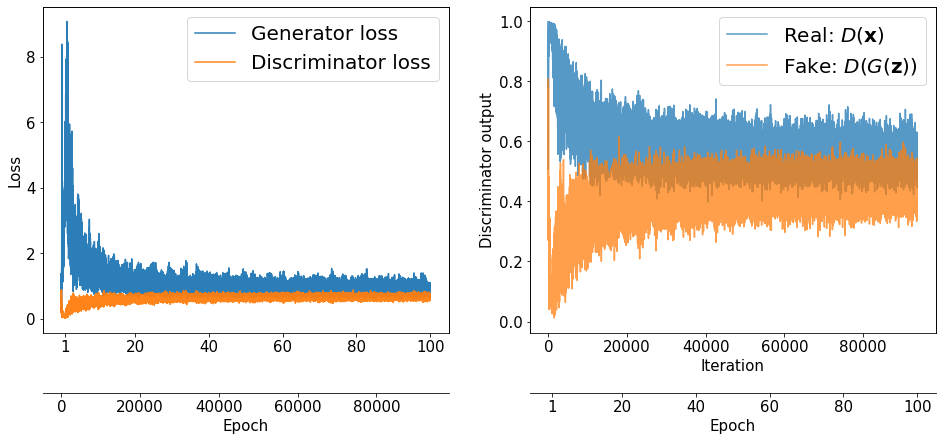

In [ ]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,2,1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label ='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1,101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1,20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax.spines['bottom'].set_position(('outward', 60))
ax.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1,2,2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()

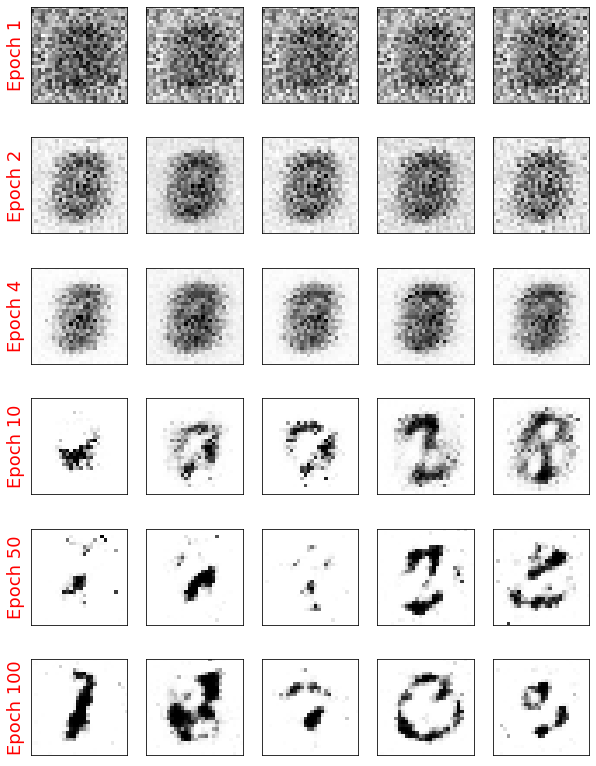

In [ ]:
selected_epochs = [1,2,4,10,50,100]
fig = plt.figure(figsize=(10,14))
for i, e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6,5, i*5 + j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, 'Epoch {}'.format(e), rotation=90, size=18, color='red', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()